## Data Link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

## Import Libraries

In [1]:
#sys libs
import os
import itertools
import shutil
import pathlib
from PIL import Image

#data handling tools
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preprocessing

## Read Data

In [2]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    
    for f in flist:
        f_path = os.path.join(foldpath , f)
        filelist = os.listdir(f_path)
        
        for file in filelist:
            fpath = os.path.join(f_path , file)
            filepaths.append(fpath)
            
            if f == 'colon_aca':
                labels.append('Colon adenocarcinoma')
            
            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')
                
            elif f == 'lung_aca':
                labels.append('Lung adenocarcinoma')
            
            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')
                
            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')
                
Files = pd.Series(filepaths , name= 'filepaths')
labels = pd.Series(labels ,name = 'labels' )
df = pd.concat([Files , labels] , axis = 1)

In [3]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

## Split data into train , validation and test

In [4]:
#Split data into train 80%
train , dummy = train_test_split(df , train_size = 0.8 , shuffle = True , random_state= 42 , stratify= df['labels'])
#Split data into validation and test 10% both
valid , test = train_test_split(dummy , train_size = 0.5 , shuffle = True , random_state= 42 , stratify= dummy['labels'])

## Image Data Generator

In [5]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

img_size = (224 , 224)

train_gen = tr_gen.flow_from_dataframe(train , x_col = 'filepaths' , y_col = 'labels' ,target_size = img_size ,
                                       class_mode= 'categorical',color_mode = 'rgb' , shuffle= True , batch_size= 64)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = True , batch_size= 64)
test_gen = ts_gen.flow_from_dataframe(test , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                     class_mode = 'categorical' , color_mode = 'rgb' , shuffle= False , batch_size = 64)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


## Sample from train data

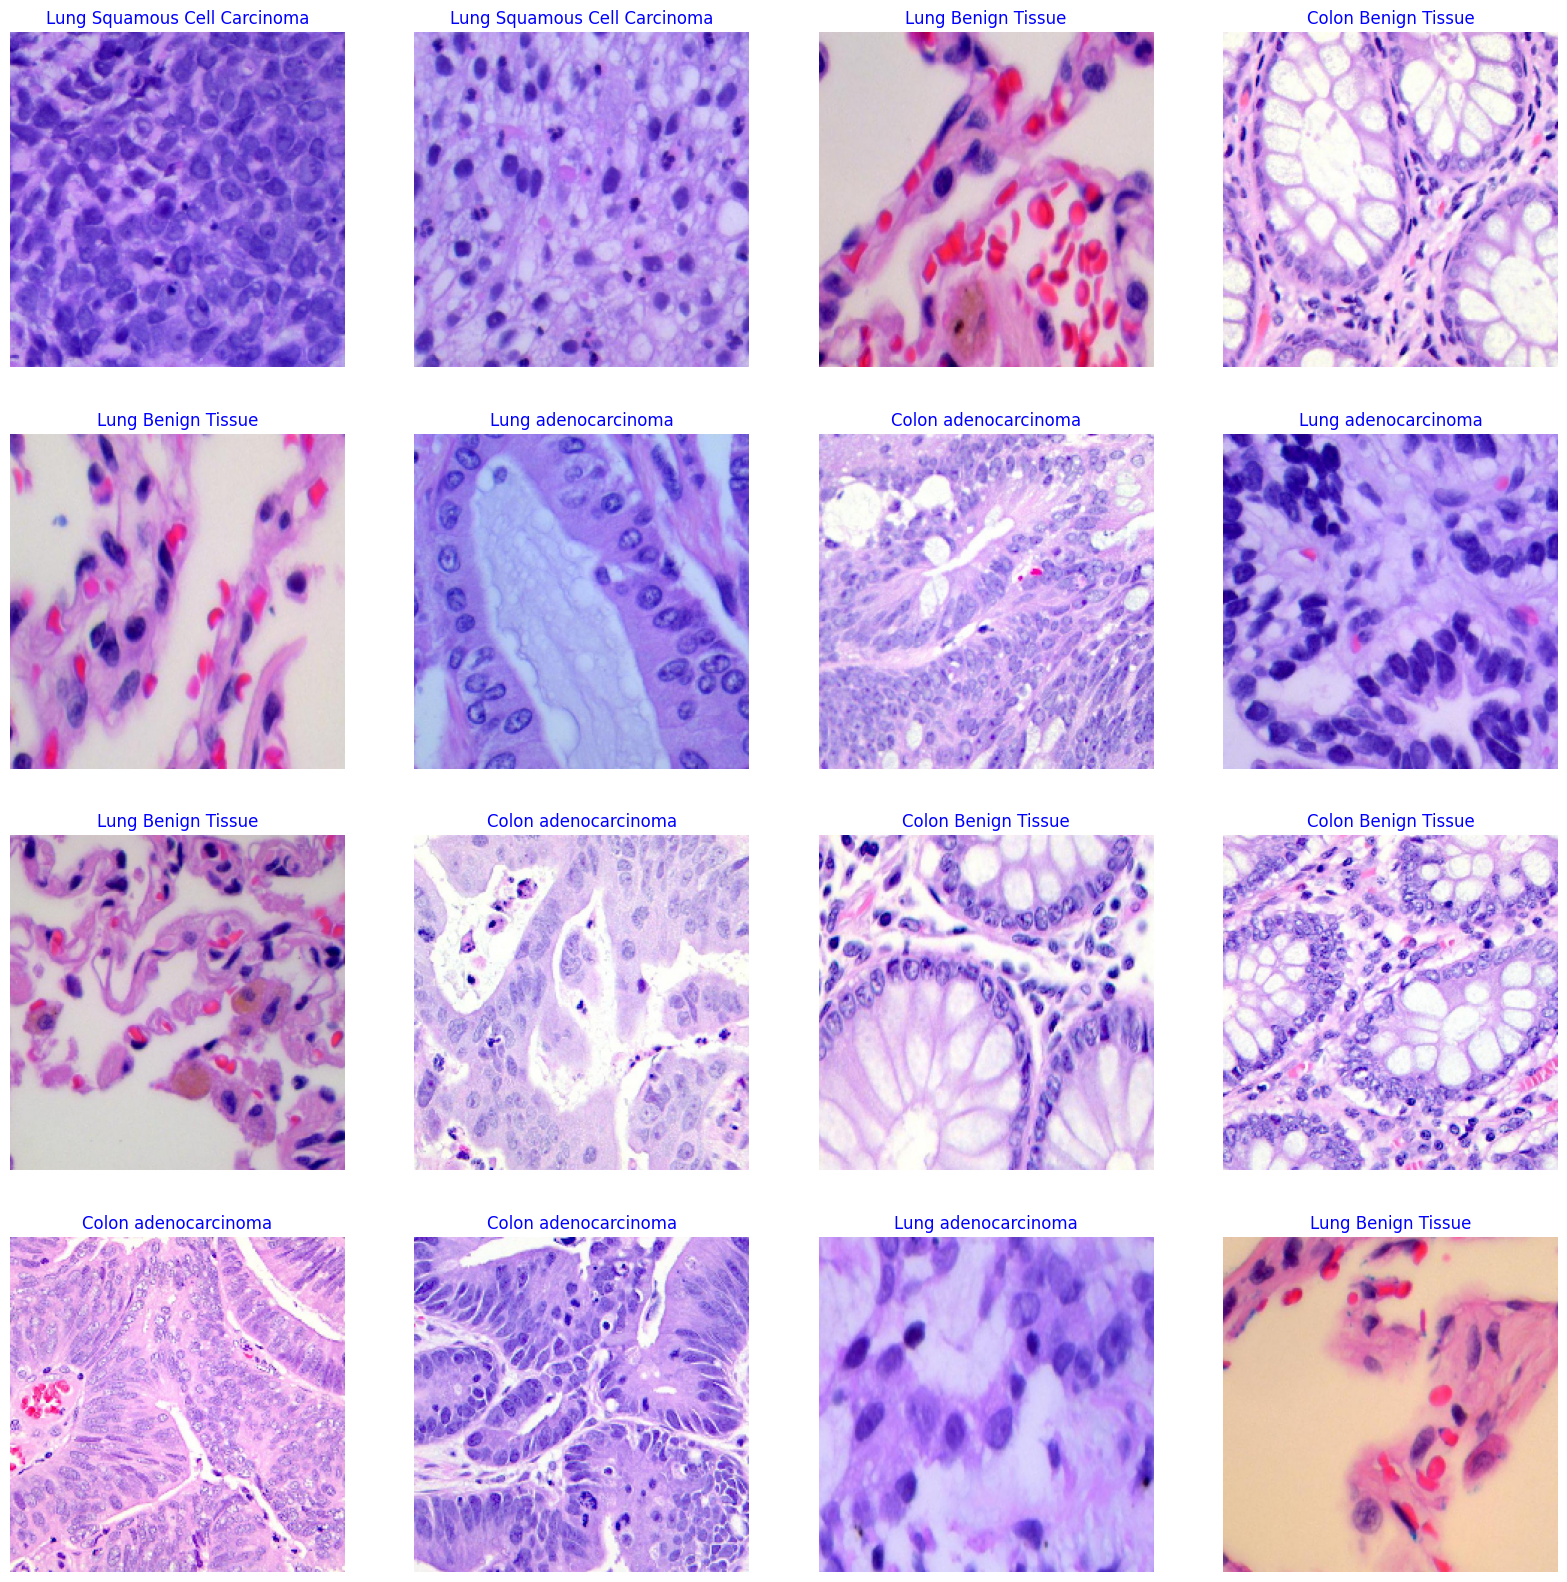

In [6]:
dict_gen = train_gen.class_indices # defines dictionary {'class': index}
classes = list(dict_gen.keys()) #define list of dictionary that have the names of the classes in the train data
images , labels = next(train_gen) #get batch size sample from train generator 

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255 # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i]) # get image index
    class_name = classes[index] # get class of image
    plt.title(class_name , color= 'blue' , fontsize = 12)
    plt.axis('off')
plt.show();

## Model Structure

In [7]:
model = Sequential([
    Conv2D(filters = 64 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu',input_shape = (img_size[0] , img_size[1] , 3)),
    Conv2D(filters = 64 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
    MaxPooling2D(pool_size = (2,2) , strides= 2),
    
    Conv2D(filters = 128 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
    MaxPooling2D(pool_size = (2,2) , strides= 2),
    
    Conv2D(filters = 256 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
    MaxPooling2D(pool_size = (2,2) , strides= 2),
    
    Conv2D(filters = 512 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
    MaxPooling2D(pool_size = (2,2) , strides= 2),
    
    Conv2D(filters = 512 ,kernel_size = (3,3) , padding = 'same' , activation= 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding= 'same' , activation= 'relu'),
    MaxPooling2D(pool_size = (2,2) , strides= 2),
    
    Flatten(),
    Dense(256 , activation= 'relu'),
    Dense(64 , activation= 'relu'),
    Dense(5 , activation= 'softmax')
    
])

model.compile(Adam(learning_rate= 0.0001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

## Iterate

In [8]:
epochs = 20
history = model.fit(x= train_gen , epochs= epochs , validation_data= valid_gen , validation_steps=None , shuffle = False , verbose= 1)

Epoch 1/20
313/313 [==============================] - 267s 786ms/step - loss: 0.6168 - accuracy: 0.7488 - val_loss: 0.9064 - val_accuracy: 0.7592
Epoch 2/20
313/313 [==============================] - 145s 463ms/step - loss: 0.3761 - accuracy: 0.8822 - val_loss: 0.7913 - val_accuracy: 0.7540
Epoch 3/20
313/313 [==============================] - 139s 445ms/step - loss: 0.3290 - accuracy: 0.8794 - val_loss: 0.6071 - val_accuracy: 0.8292
Epoch 4/20
313/313 [==============================] - 141s 449ms/step - loss: 0.2104 - accuracy: 0.9280 - val_loss: 0.6190 - val_accuracy: 0.8176
Epoch 5/20
313/313 [==============================] - 135s 430ms/step - loss: 0.1609 - accuracy: 0.9434 - val_loss: 0.0893 - val_accuracy: 0.9672
Epoch 6/20
313/313 [==============================] - 133s 425ms/step - loss: 0.0900 - accuracy: 0.9660 - val_loss: 0.1263 - val_accuracy: 0.9624
Epoch 7/20
313/313 [==============================] - 137s 436ms/step - loss: 0.0726 - accuracy: 0.9801 - val_loss: 1.0693 -

## Model Performance

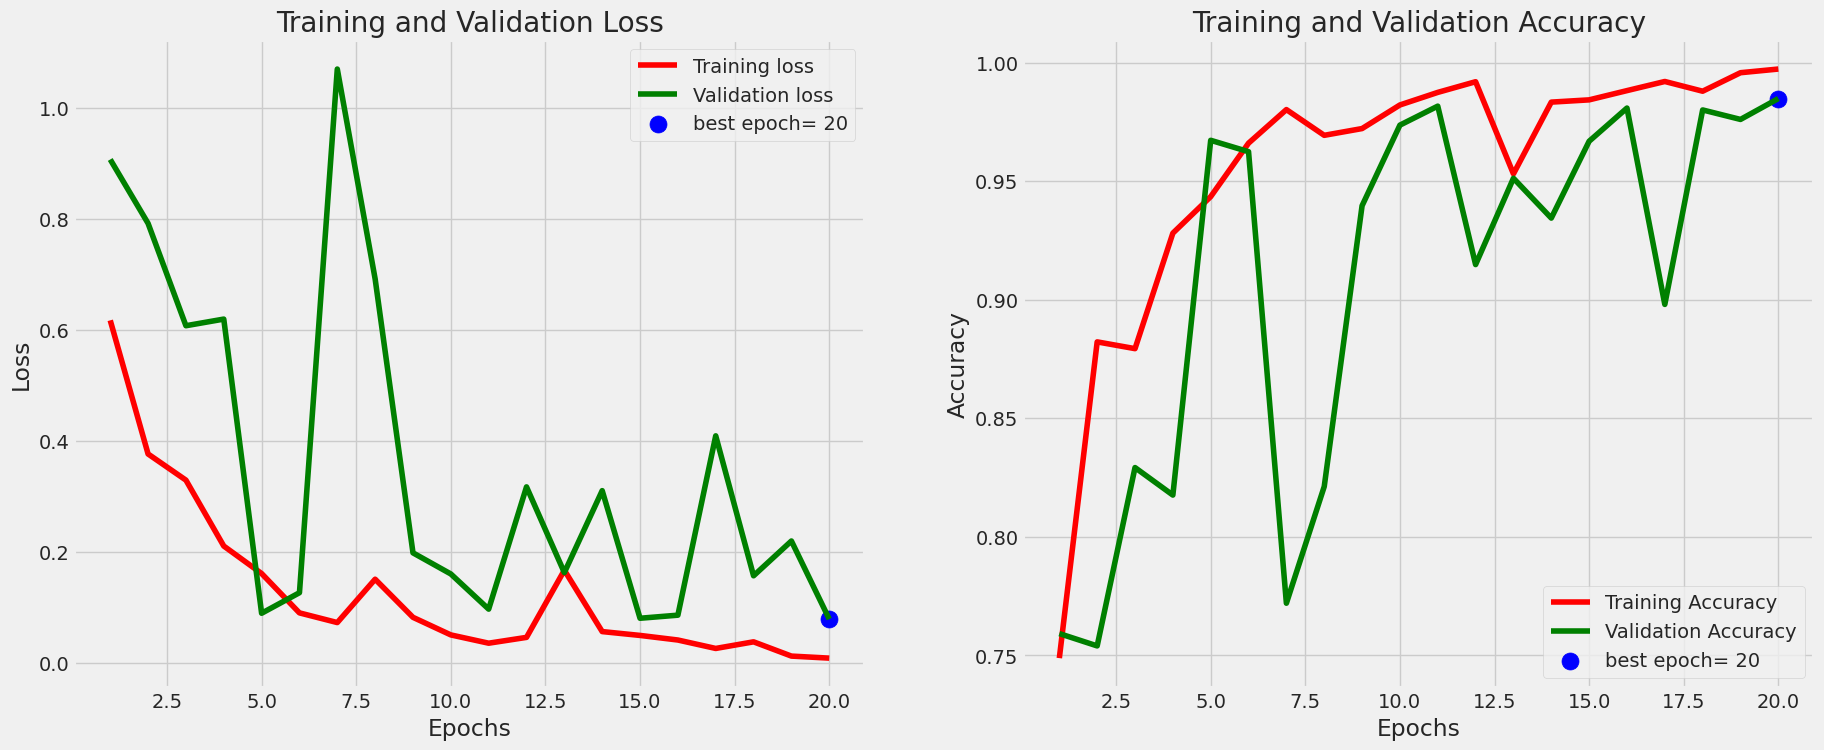

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [11]:
ts_length = len(test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 [==============================] - 33s 657ms/step - loss: 0.1016 - accuracy: 0.9824
Train Loss:  0.003067848039790988
Train Accuracy:  0.9987499713897705
--------------------
Valid Loss:  0.056382566690444946
Valid Accuracy:  0.9851999878883362
--------------------
Test Loss:  0.10164908319711685
Test Accuracy:  0.9824000000953674


## Model Prediction

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

## Confusion Matrix and Classification Report

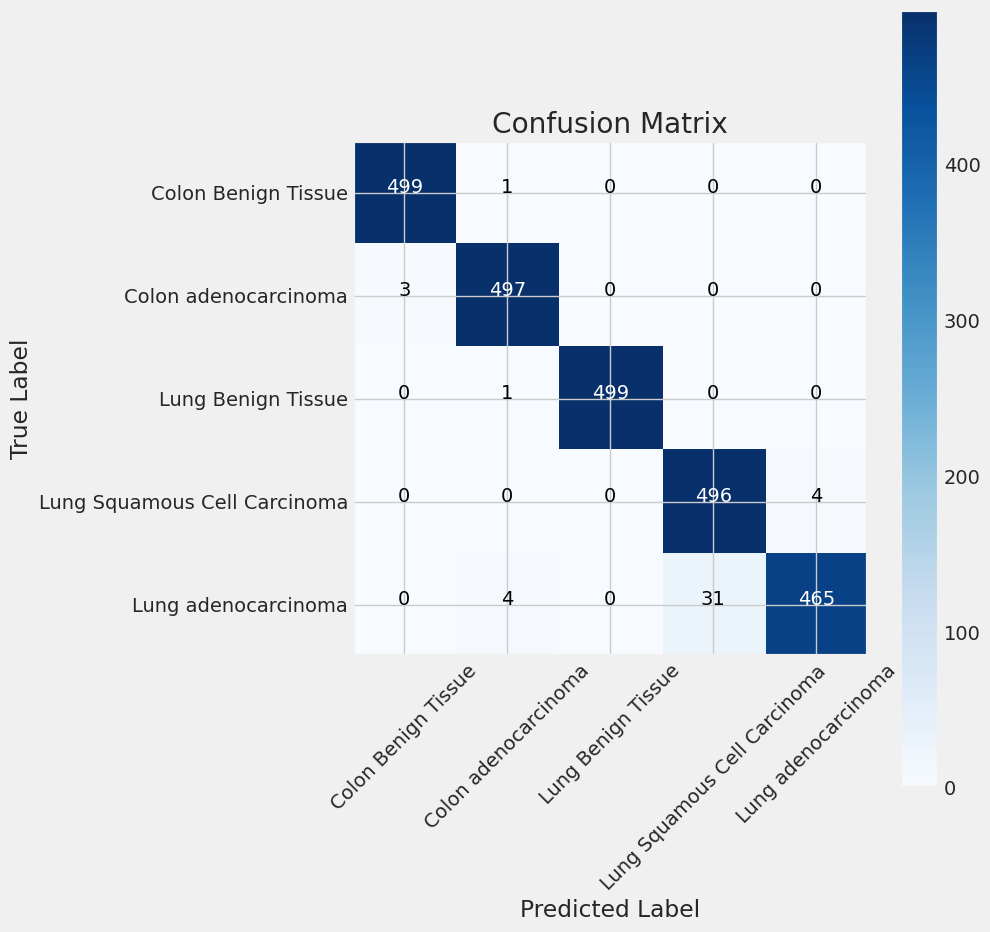

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

         Colon Benign Tissue       0.99      1.00      1.00       500
        Colon adenocarcinoma       0.99      0.99      0.99       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.94      0.99      0.97       500
         Lung adenocarcinoma       0.99      0.93      0.96       500

                    accuracy                           0.98      2500
                   macro avg       0.98      0.98      0.98      2500
                weighted avg       0.98      0.98      0.98      2500

